# Tempo

Tempo should be measured as either the amount of passes and dribbles per time frame, or the speed of those per time frame. It could also include for example goal kicks, free kicks, corner kicks and even shots. Let's start with passes and dribbles.

In [423]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [424]:
# read data
df = pd.read_csv('../data/timelines.csv')

In [425]:
df.head(1)

,tournament_id,match_id,event_type,period,result,team,seconds_from_period_start,start_time,end_time,start_position_x,...,speed,home_team,away_team,home_team_int,away_team_int,age,year,distance,duration,int_level
0,57,1257,KickOff,1.0,NaN,Home,NaN,NaN,NaN,NaN,...,NaN,FC Espoo T2010,EPS T2010,0,0,F12,2022,NaN,NaN,0


In [426]:
# group by matches
df_matches = df.groupby('match_id')

In [427]:
# get matches with time gaps between events of over 50 seconds
threshold = 50

# Compute time gaps
df['time_gap'] = df_matches['seconds_from_period_start'].diff()

# Identify matches with gaps above threshold
df['gap_exceeds_threshold'] = df['time_gap'] > threshold

In [428]:
# get matches where two consecutive events are kick-offs
df['consecutive_kickoffs'] = (df['event_type'] == 'KickOff') & (df['event_type'].shift(1) == 'KickOff')

In [429]:
# remove matches where two consecutive events are kickoffs and have at least a 50 second gap
remove_match_indices = df[(df['gap_exceeds_threshold'] == True) & (df['consecutive_kickoffs'] == True)]['match_id'].unique()
df = df[~df['match_id'].isin(remove_match_indices)]

### Plotting

In [430]:
# Function to calculate passes & dribbles per timeframe
def calculate_tempo(df, timeframe):
    
    # Create time bins
    df['time_bin'] = (df['seconds_from_period_start'] // timeframe) * timeframe
    
    # Count passes & dribbles per time bin
    tempo_df = df[df['event_type'].isin(['Pass', 'Dribble'])] \
        .groupby(['match_id', 'time_bin', 'age', 'int_level']).size().reset_index(name='tempo')
    
    return tempo_df

In [431]:
# df[(df['match_id'] == 1237) & (df['seconds_from_period_start'] > 121)]

In [432]:
# passes and dribbles
df_passes_dribbles = df[df['event_type'].isin(['Pass', 'Dribble'])]

df_grouped = df_passes_dribbles.groupby(['age', 'period'])

for i, (group_name, df_group) in enumerate(df_grouped):
    print(group_name)
    print(calculate_tempo(df_group, 240))

('F12', 1.0)
     match_id  time_bin  age  int_level  tempo
0        1237       0.0  F12          1     21
1        1237     240.0  F12          1     39
2        1237     480.0  F12          1     29
3        1237     720.0  F12          1     27
4        1237     960.0  F12          1     48
5        1237    1200.0  F12          1      4
6        1238       0.0  F12          0     32
7        1238     240.0  F12          0     34
8        1238     480.0  F12          0     31
9        1238     720.0  F12          0     22
10       1238     960.0  F12          0     42
11       1238    1200.0  F12          0      3
12       1240     240.0  F12          0      3
13       1240     480.0  F12          0     17
14       1240     720.0  F12          0     35
15       1240     960.0  F12          0     40
16       1240    1200.0  F12          0      1
17       1241       0.0  F12          1     28
18       1241     240.0  F12          1     32
19       1241     480.0  F12          1     25


We can tell that the second period looks useless in all age groups, only a few time frames in some matches. We should ignore these completely. Also, we should be cautios about the last time frame of the match as it is not probably of equal duration to the other frames.

In [433]:
# include only period 1 events
df = df[df['period'] == 1.0]

In [434]:
# get the tempo dataframe
tempo_df = calculate_tempo(df, 240)

In [435]:
# Find the max time_bin for each match_id
max_time_bins = tempo_df.groupby('match_id')['time_bin'].transform('max')

# Keep only rows where time_bin is NOT the max for that match
tempo_df = tempo_df[tempo_df['time_bin'] != max_time_bins]

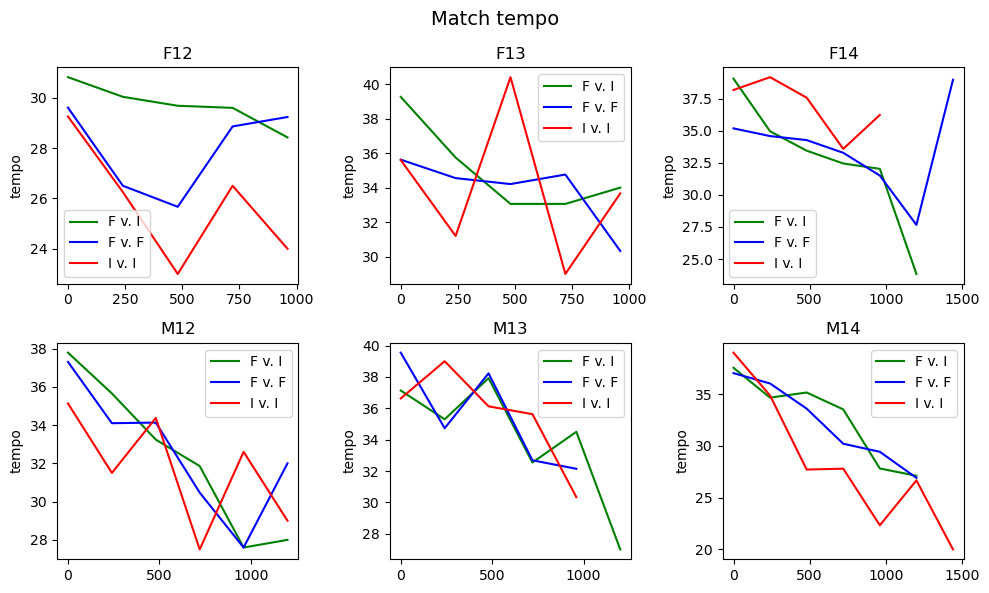

In [436]:
# plot histograms of pass speeds per age group
fig, axes = plt.subplots(2,3, figsize=(10,6))

colors = ['blue', 'green', 'red']

axes = axes.flatten()

df_grouped = tempo_df.groupby('age')

for i, (group_name, df_group) in enumerate(df_grouped):

    # Group by int_level within each age group
    int_levels = df_group['int_level'].unique()  # Get unique intensity levels

    for level in int_levels: # [1, 0, 2]
        subset = df_group[df_group['int_level'] == level]
        avg = subset.groupby('time_bin')['tempo'].mean()
        axes[i].plot(avg, color=colors[level], label=f'{['F v. F', 'F v. I', 'I v. I'][level]}')

    axes[i].set_title(group_name)
    axes[i].legend()  # Add legend to differentiate int_level categories
    axes[i].set_ylabel('tempo')

fig.suptitle('Match tempo', fontsize=14)
plt.tight_layout()